# Multi-level Regression

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(12345)

In this notebook we demo how to perform a Bayesian multi-level regression.  
We'll use a multi-level dataset included with `statsmodels` containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). Since the weight of each pig is measured multiple times, we'll estimate a model that allows varying intercepts and slopes for time, for each pig.

### Load data

In [3]:
# Load up data from statsmodels
data = sm.datasets.get_rdataset("dietox", "geepack").data
data.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


### Model

$$
Y_i = \beta_{0, i} + \beta_{1, i} X + \epsilon_i
$$

with 

$\beta_{0, i} = \beta_0 + \alpha_{0, i}$  
$\beta_{1, i} = \beta_1 + \alpha_{1, i}$  


where $\beta_0$ and $\beta_1$ are usual common intercept and slope you find in a linear regression. $\alpha_{0, i}$ and $\alpha_{1, i}$ are the group specific components for the pig $i$, influencing the intercept and the slope respectively. Finally $\epsilon_i$ is the random error we always see in this type of models, assumed to be Gaussian with mean 0. Note that here we use "common" and "group specific" effects to denote what in many fields are known as "fixed" and "random" effects, respectively.

We use the formula syntax to specify the model. Previously, you had to specify common and group specific components separately. Now, thanks to [formulae](https://github.com/bambinos/formulae), you can specify model formulas just as you would do with R packages like [lme4](https://CRAN.R-project.org/package=lme4) and [brms](https://CRAN.R-project.org/package=brms). In a nutshell, the term on the left side tells `Weight` is the response variable, `Time` on the right-hand side tells we include a main effect for the variable `Time`, and `(Time|Pig)` indicates we want to allow a each pig to have its own slope for `Time` as well as its own intercept (which is implicit). If we only wanted different intercepts, we would have written `Weight ~ Time + (1 | Pig)` and if we wanted slopes specific to each pig without including a pig specific intercept, we would write `Weight ~ Time + (0 + Time | Pig)`.

In [4]:
model = bmb.Model("Weight ~ Time + (Time|Pig)", data)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Weight_sigma, Time|Pig_offset, Time|Pig_sigma, 1|Pig_offset, 1|Pig_sigma, Intercept, Time]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can print the model to have a summary of the details

In [5]:
model

Formula: Weight ~ Time + (Time|Pig)
Family name: Gaussian
Link: identity
Observations: 861
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 60.7258, sigma: 133.0346)
    Time ~ Normal(mu: 0.0, sigma: 18.1283)

  Group-level effects
    1|Pig ~ Normal(mu: 0, sigma: HalfNormal(sigma: 133.0346))
    Time|Pig ~ Normal(mu: 0, sigma: HalfNormal(sigma: 18.1283))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 24.9644)


------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Since we have not specified prior distributions for the parameters in the model, Bambi has chosen sensible defaults for us. We can explore these priors through samples generated from them with a call to `Model.plot_priors()`, which plots a kernel density estimate for each prior.

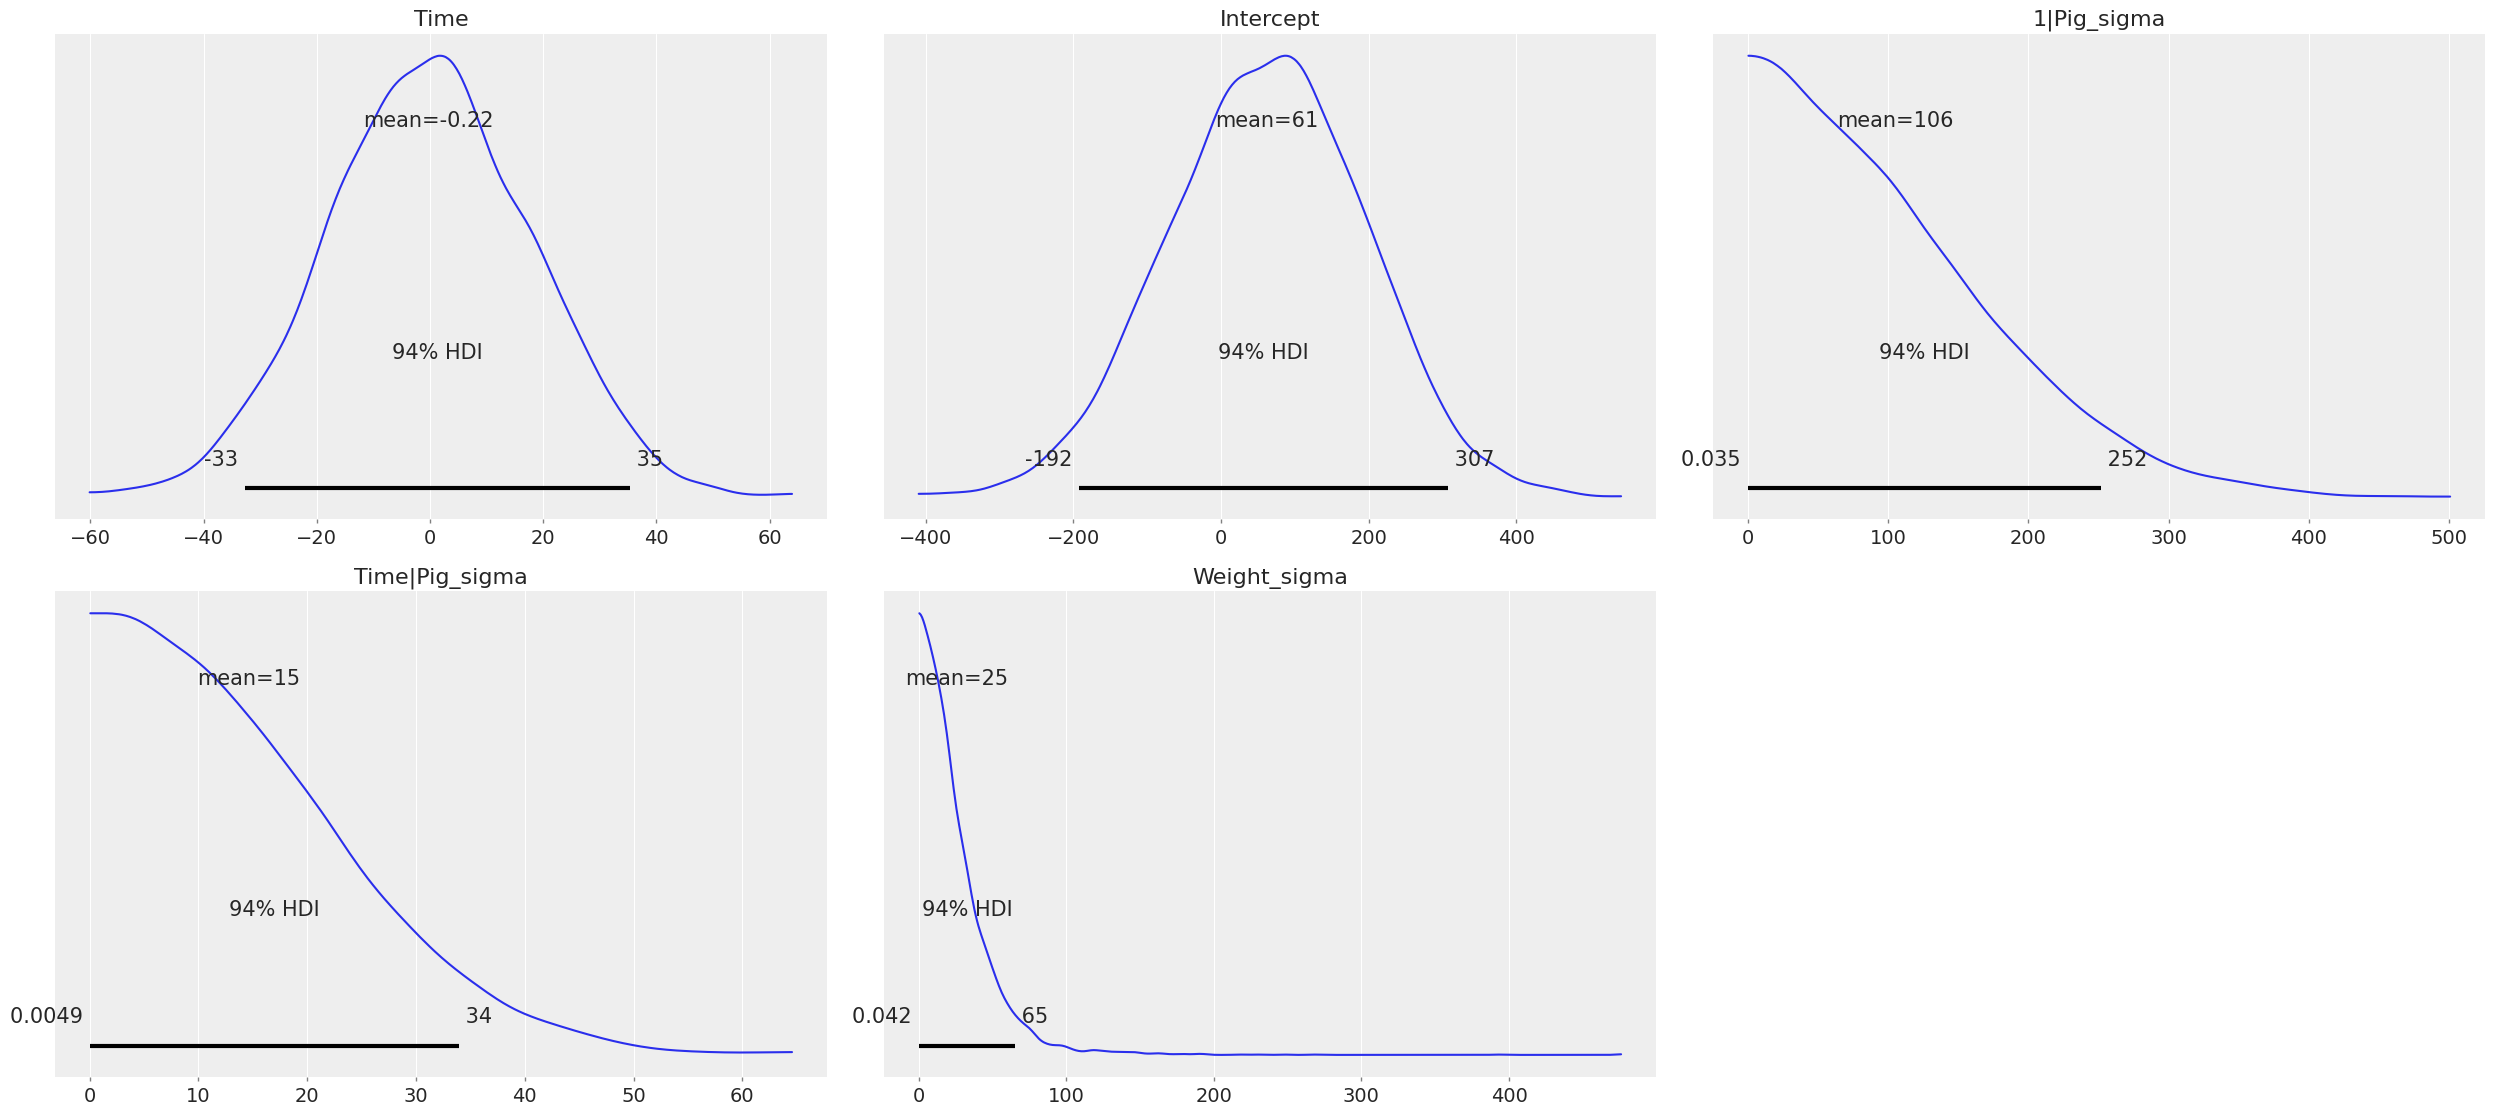

In [6]:
model.plot_priors();

Now we are ready to check the results. Using `az.plot_trace()` we get traceplots that show the values sampled from the posteriors and density estimates that gives us an idea of the shape of the posterior distribution of our parameters. 

In this case it is very convenient to use `compact=True`. We tell ArviZ to plot all the group specific posteriors in the same panel which saves space and makes it easier to compare group specific posteriors. Thus, we'll have a panel with all the group specific intercepts, and another panel with all the group specific slopes. If we used `compact=False`, which is the default, we would end up with a huge number of panels which would make the plot unreadable.

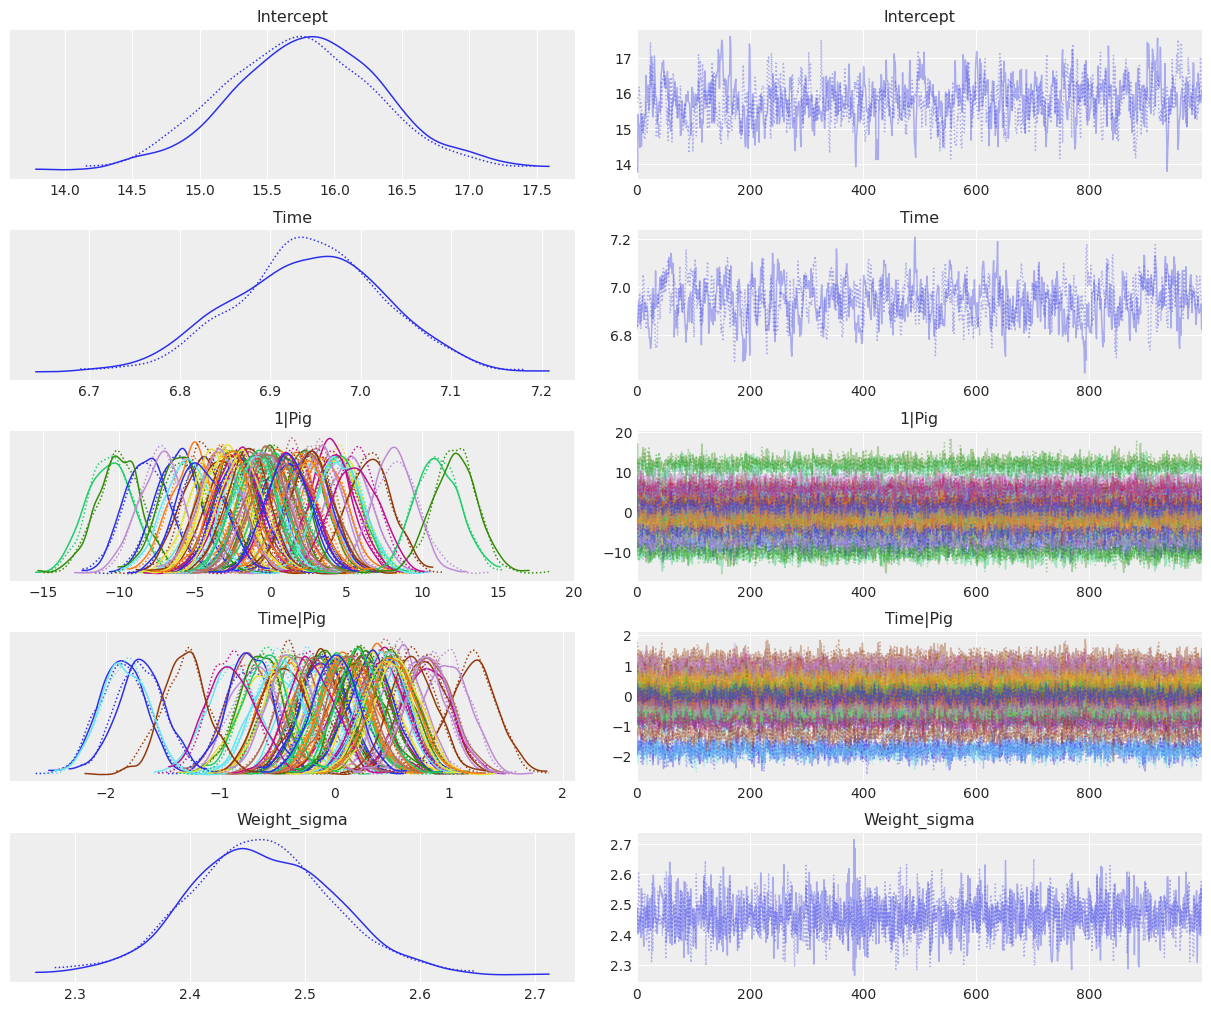

In [7]:
# Plot posteriors
az.plot_trace(
    results,
    var_names=["Intercept", "Time", "1|Pig", "Time|Pig", "Weight_sigma"],
    compact=True,
);

The same plot could have been generated with less typing by calling 

`az.plot_trace(results, var_names=["~1|Pig_sigma", "~Time|Pig_sigma"], compact=True);`

which uses an alternative notation to pass `var_names` based on the negation symbol in Python, `~`. There we are telling ArviZ to plot all the variables in the InferenceData object `results`, except from `1|Pig_sigma` and `Time|Pig_sigma`.  
Can't believe it? Come on, run this notebook on your side and have a try! 

The plots generated by `az.plot_trace()` are enough to be confident that the sampler did a good job and conclude about plausible values for the distribution of each parameter in the model. But if we want to, and it is a good idea to do it, we can get umerical summaries for the posteriors with `az.summary()`. 

In [8]:
az.summary(results, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "Weight_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.777,0.590,14.607,16.887,0.030,0.021,384.0,697.0,1.01
Time,6.943,0.083,6.791,7.097,0.004,0.003,396.0,738.0,1.00
1|Pig_sigma,4.550,0.425,3.747,5.307,0.016,0.011,774.0,1119.0,1.00
Time|Pig_sigma,0.662,0.063,0.551,0.784,0.003,0.002,602.0,1065.0,1.00
Weight_sigma,2.461,0.063,2.342,2.580,0.001,0.001,2376.0,1606.0,1.00


### Estimated regression line

Here we'll visualize the regression equations we have sampled for a particular pig and then we'll compare
the mean regression equation for all the 72 pigs in the dataset.  

In the following plot we can see the 2000 linear regressions we have sampled for the pig '4601'.  The mean regression line is plotted in black and the observed weights for this pig are respresented by the blue dots.

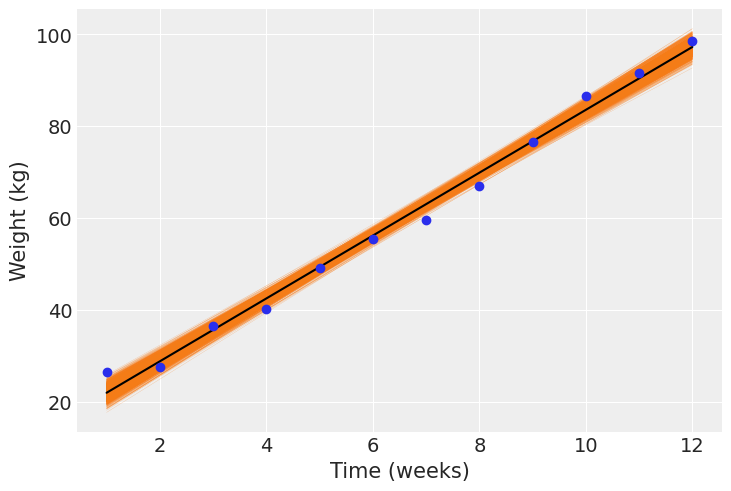

In [9]:
# The ID of the first pig is '4601'
data_0 = data[data["Pig"] == 4601][["Time", "Weight"]]
time = np.array([1, 12])

intercept_common = results.posterior["Intercept"].stack(draws=("chain", "draw"))
slope_common = results.posterior["Time"].stack(draws=("chain", "draw"))

intercept_specific_0 = results.posterior["1|Pig"].stack(draws=("chain", "draw"))[0]
slope_specific_0 = results.posterior["Time|Pig"].stack(draws=("chain", "draw"))[0]

a = (intercept_common + intercept_specific_0).values
b = (slope_common + slope_specific_0).values

plt.plot(time, a + b * time[:, None], color="C1", lw=0.1, zorder=1)
plt.plot(time, a.mean() + b.mean() * time, color="black", zorder=1)
plt.scatter(data_0["Time"], data_0["Weight"], zorder=2)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

Next, we calculate the mean regression line for each pig and show them together in one plot. Here we clearly see each pig has a different pair of intercept and slope.

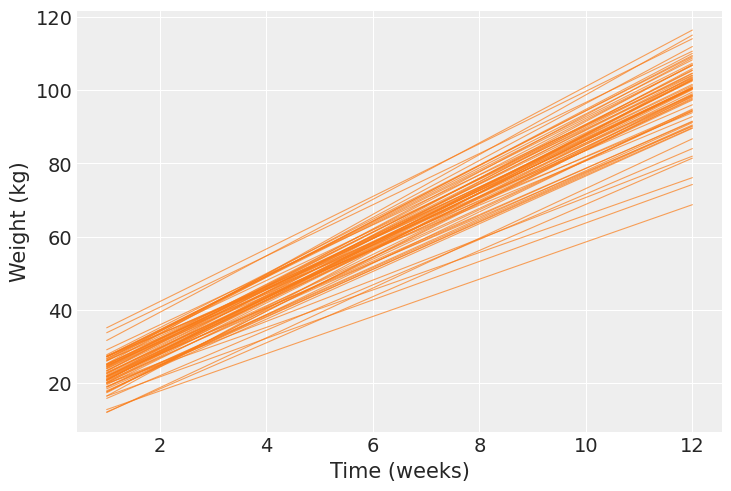

In [10]:
intercept_group_specific = results.posterior["1|Pig"].stack(draws=("chain", "draw"))
slope_group_specific = results.posterior["Time|Pig"].stack(draws=("chain", "draw"))
a = (intercept_common.mean() + intercept_group_specific.mean(axis=1)).values
b = (slope_common.mean() + slope_group_specific.mean(axis=1)).values
plt.plot(time, a + b * time[:, None], color="C1", alpha=0.7, lw=0.8)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

We can get credible interval plots with ArviZ. Here the line indicates a 94% credible interval calculated as higher posterior density, the thicker line represents the interquartile range and the dot is the median. We can quickly note two things:

* The uncertainty about the intercept estimate is much higher than the uncertainty about the `Time` slope.
* The credible interval for `Time` is far away from 0, so we can be confident there's a positive relationship
the `Weight` of the pigs and `Time`.  

We're not making any great discovering by stating that as time passes we expect the pigs to weight more, but this very simple example can be used as a starting point in applications where the relationship between the variables
is not that clear beforehand.

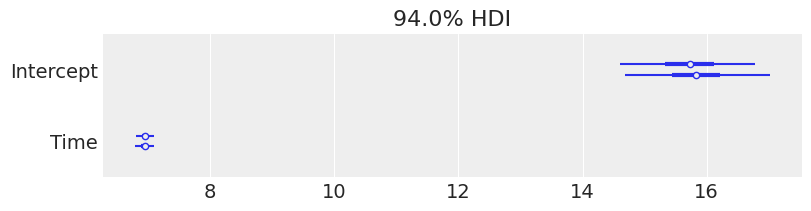

In [11]:
az.plot_forest(
    results,
    var_names=["Intercept", "Time"],
    figsize=(8, 2),
);

We can also plot the posterior overlayed with a region of practical equivalence (ROPE). This region indicates a range of parameter values that are considered to be practically equivalent to some reference value of interest to the particular application, for example 0. In the following plot we can see that all our posterior distributions fall outside of this range.

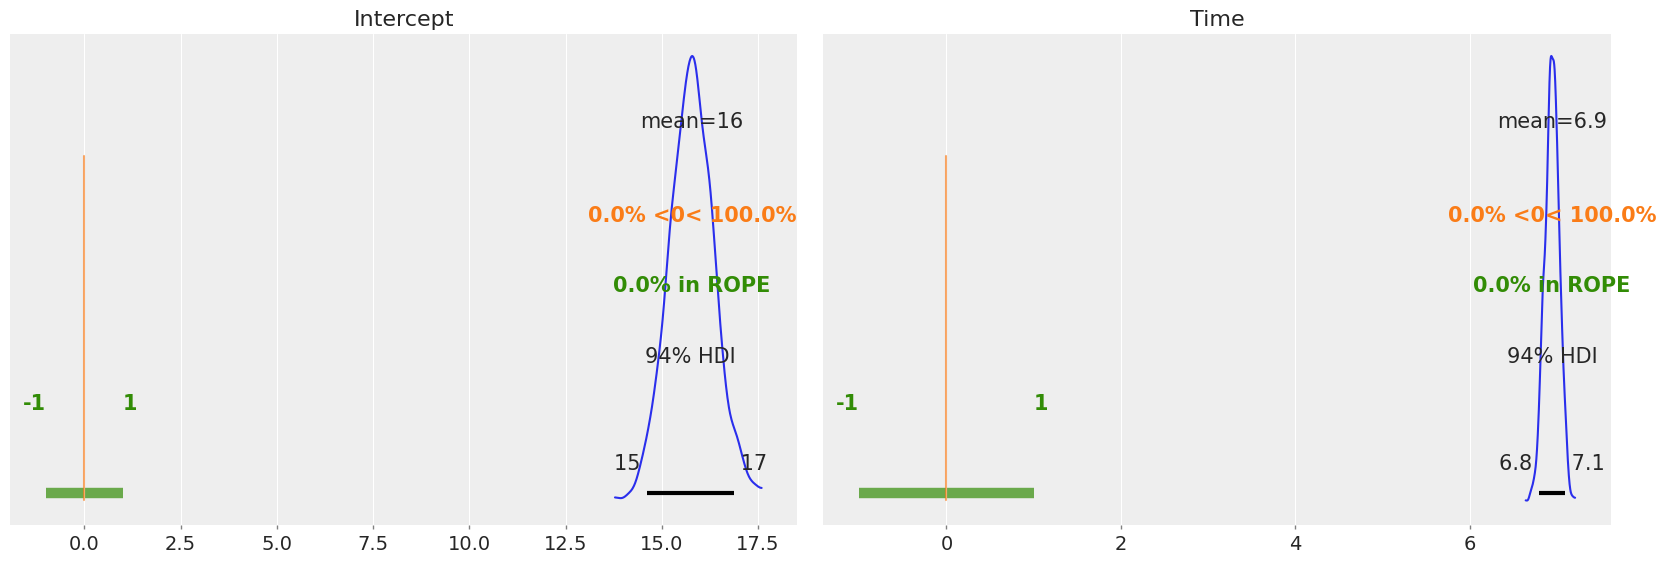

In [12]:
az.plot_posterior(results, var_names=["Intercept", "Time"], ref_val=0, rope=[-1, 1]);

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jul 27 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

json       : 2.0.9
statsmodels: 0.12.2
matplotlib : 3.3.3
bambi      : 0.5.0
arviz      : 0.11.2
numpy      : 1.20.1

Watermark: 2.1.0

